# Document Clustering

We take the example from scikit-learn (see [here](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py) and run it on these documents.

## Config

In [1]:
n_components = 30 # Perform a SVT reduction - improve accuracy
n_cluster = 10 # How many clusters to try to divide things into?

# Setup

In [2]:
from config import text_file_info, word_vectors

from collections import defaultdict

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import _check_stop_list
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Text loading and vectorizing

Do the regular feature extraction and then reduce the number of components using SVD.

In [3]:
%%time
text_by_area = list(text_file_info())
x, vectorizer = word_vectors([f[2] for f in text_by_area])

CPU times: user 2.54 s, sys: 570 ms, total: 3.11 s
Wall time: 8.13 s


In [4]:
x.shape

(1566, 4000)

In [5]:
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [6]:
%%time
x_comp = lsa.fit_transform(x)

CPU times: user 2.39 s, sys: 2.09 s, total: 4.48 s
Wall time: 592 ms


## Clustering

Using k-means

In [7]:
km = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=1, verbose=True)

In [8]:
%%time
km.fit(x_comp)

Initialization complete
Iteration 0, inertia 1200.94249332955
Iteration 1, inertia 777.8203445452102
Iteration 2, inertia 756.5539923632904
Iteration 3, inertia 750.231698873486
Iteration 4, inertia 747.4077183021097
Iteration 5, inertia 744.6322204419322
Iteration 6, inertia 741.7662429475806
Iteration 7, inertia 737.9867602219574
Iteration 8, inertia 735.290005522846
Iteration 9, inertia 733.7507927791586
Iteration 10, inertia 732.2643421957806
Iteration 11, inertia 731.1889113185824
Iteration 12, inertia 730.7543824959677
Iteration 13, inertia 730.1215163108924
Iteration 14, inertia 729.7343447492568
Iteration 15, inertia 729.5910127482097
Iteration 16, inertia 729.5747308910398
Converged at iteration 16: strict convergence.
CPU times: user 964 ms, sys: 390 ms, total: 1.35 s
Wall time: 181 ms


KMeans(max_iter=100, n_clusters=10, n_init=1, verbose=True)

Dump some info about each of the clusters we found - in particular, the important terms as we can use that to elminiate terms that shouldn't be a factor here.

In [9]:
def dump_keywords(km, vectorizer, n_clusters):
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()
        
dump_keywords(km, vectorizer, n_cluster)

Cluster 0: dark cosmic matter gravitational cmb cosmological galaxy ray survey wave
Cluster 1: decays belle decay lhcb lepton flavor rare violation qcd meson
Cluster 2: neutrino neutrinos usa dune sterile department reactor icecube oscillation nuclear
Cluster 3: detectors readout resolution timing silicon scintillator calorimeter pixel sensors mu2e
Cluster 4: accelerator laser plasma electron collider accelerators power srf muon bunch
Cluster 5: students computing accelerator software community research learning science education simulation
Cluster 6: magnet magnets hts superconducting nb3sn conductor dipole rebco cable accelerator
Cluster 7: dark matter axion photon quantum detection search detectors cavity cosmic
Cluster 8: lattice qcd quantum quark theory parton gluon calculations collisions lhc
Cluster 9: higgs lhc boson collider fcc tev colliders production couplings atlas


In [10]:
def cluster_df(text_by_area, km):
    cluster_list = []
    for (f_name, f_area, _), i_cluster in zip(text_by_area, km.labels_):
        cluster_list.append({'name': f_name, 'area': f_area, 'cluster': int(i_cluster)})
    return pd.DataFrame(cluster_list)
clusters = cluster_df(text_by_area, km)

In [11]:
clusters

,name,area,cluster
0,SNOWMASS21-AF-TOPIC0-001,AF,4
1,SNOWMASS21-AF0-015,AF,4
2,SNOWMASS21-AF0_AF0-091,AF,4
3,SNOWMASS21-AF0_AF0-215,AF,4
4,SNOWMASS21-AF0_AF0-229,AF,4
...,...,...,...
1561,SNOWMASS21-UF0_UF0_Garcia-Sciveres-001,UF,5
1562,SNOWMASS21-UF1_UF4-RF4_RF3_ODonnell-007,UF,2
1563,SNOWMASS21-UF4_UF3-NF5_NF6-CF1_CF0-IF3_IF0-Com...,UF,7
1564,SNOWMASS21-UF6_UF0-NF10_NF0-RF4_RF0-CF1_CF0-IF...,UF,3


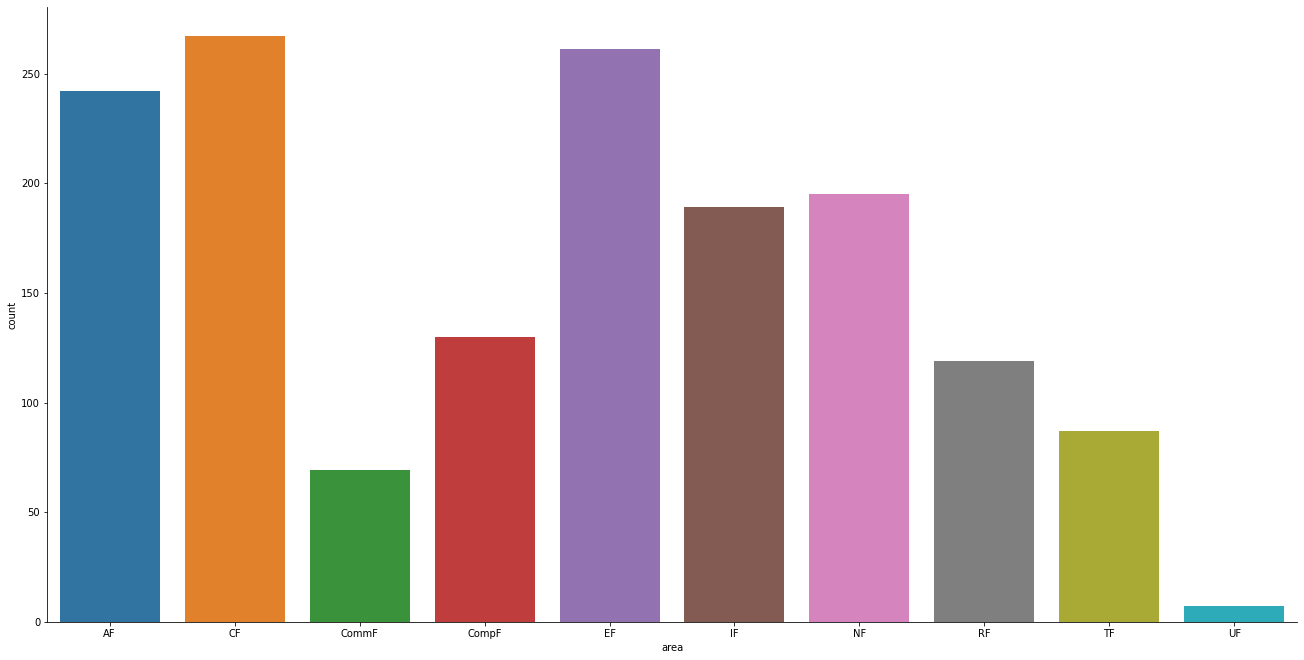

In [13]:
g = sns.catplot('area', kind='count', data=clusters)
g.fig.set_figwidth(20)
g.fig.set_figheight(10)
plt.savefig('../web/assets/images/lois-by-frontier.png')

And how did the clustering do?

In [ ]:
g = sns.catplot('area', kind='count', col='cluster', col_wrap=3, data=clusters)

## Proper number of clusters

To scan for the proper number of clusters we maximize the silhouette score - which is a measure of how inside a datapoint is in each culster vs out far it is from the rest. It ranges from [1,-1].

In [ ]:
def cluster_s_score(x_comp, number_of_clusters: int):
    print (f'clustering for {number_of_clusters}')
    km = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, verbose=False, random_state=False)
    km.fit(x_comp)
    return silhouette_score(x_comp, km.labels_)

In [ ]:
scan = [(int(n_c), cluster_s_score(x_comp, int(n_c))) for n_c in np.linspace(2, 100, num=30)]

In [ ]:
scan

In [ ]:
best_n = 25
km = KMeans(n_clusters=best_n, init='k-means++', max_iter=100, n_init=1, verbose=False, random_state=False)
km.fit(x_comp)
dump_keywords(km, vectorizer, best_n)

In [ ]:
best_clusters = cluster_df(text_by_area, km)

In [ ]:
g = sns.catplot('area', kind='count', col='cluster', col_wrap=3, data=best_clusters)